In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_conv_5_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_only_conv_conv_5_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 8)          32        
_________________________________________________________________
activation (Activation)      (None, 15976, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3994, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 31952)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                511248    
Total params: 511,488
Trainable params: 511,472
Non-trainable params: 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3810 - acc: 0.2583
Epoch 00001: val_loss improved from inf to 2.00441, saving model to model/checkpoint/1D_CNN_BN_1_only_conv_checkpoint/001-2.0044.hdf5
36805/36805 [==============================] - 9s 255us/sample - loss: 2.3811 - acc: 0.2583 - val_loss: 2.0044 - val_acc: 0.3522
Epoch 2/500
36544/36805 [============================>.] - ETA: 0s - loss: 1.6398 - acc: 0.4739
Epoch 00002: val_loss improved from 2.00441 to 1.86095, saving model to model/checkpoint/1D_CNN_BN_1_only_conv_checkpoint/002-1.8609.hdf5
36805/36805 [==============================] - 7s 198us/sample - loss: 1.6390 - acc: 0.4742 - val_loss: 1.8609 - val_acc: 0.4034
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3685 - acc: 0.5638
Epoch 00003: val_loss improved from 1.86095 to 1.75336, saving model to model/checkpo

Epoch 58/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9940
Epoch 00058: val_loss did not improve from 1.74330
36805/36805 [==============================] - 8s 209us/sample - loss: 0.0560 - acc: 0.9940 - val_loss: 3.5909 - val_acc: 0.4391
Epoch 59/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0603 - acc: 0.9929
Epoch 00059: val_loss did not improve from 1.74330
36805/36805 [==============================] - 8s 210us/sample - loss: 0.0602 - acc: 0.9930 - val_loss: 3.7059 - val_acc: 0.4279
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.9945
Epoch 00060: val_loss did not improve from 1.74330
36805/36805 [==============================] - 8s 212us/sample - loss: 0.0524 - acc: 0.9945 - val_loss: 3.6987 - val_acc: 0.4358
Epoch 61/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9954
Epoch 00061: val_loss did not improve from 1.74330
36805/36805 [========

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9965
Epoch 00088: val_loss did not improve from 1.74330
36805/36805 [==============================] - 8s 210us/sample - loss: 0.0323 - acc: 0.9965 - val_loss: 4.2212 - val_acc: 0.4232
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9945
Epoch 00089: val_loss did not improve from 1.74330
36805/36805 [==============================] - 8s 213us/sample - loss: 0.0393 - acc: 0.9945 - val_loss: 4.2622 - val_acc: 0.4249
Epoch 90/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9961
Epoch 00090: val_loss did not improve from 1.74330
36805/36805 [==============================] - 8s 210us/sample - loss: 0.0344 - acc: 0.9961 - val_loss: 4.2600 - val_acc: 0.4328
Epoch 91/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9964
Epoch 00091: val_loss did not improve from 1.74330
36805/36805 [========

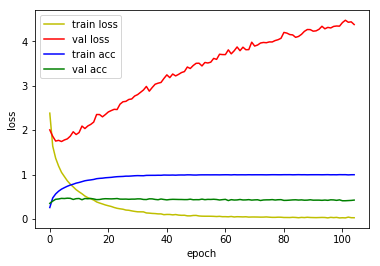

4815/4815 [==============================] - 1s 191us/sample - loss: 1.8429 - acc: 0.4289
Loss: 1.8428832955325751 Accuracy: 0.42886811

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1350 - acc: 0.3176
Epoch 00001: val_loss improved from inf to 1.79621, saving model to model/checkpoint/1D_CNN_BN_2_only_conv_checkpoint/001-1.7962.hdf5
36805/36805 [==============================] - 13s 342us/sample - loss: 2.1341 - acc: 0.3178 - val_loss: 1.7962 - val_acc: 0.4067
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5566 - acc: 0.5060
Epoch 00002: val_loss improved from 1.79621 to 1.46232, saving model to model/checkpoint/1D_CNN_BN_2_only_conv_checkpoint/002-1.4623.hdf5
36805/36805 [==============================] - 11s 307us/sample - loss: 1.5562 - acc: 0.5062 - val_loss: 1.4623 - val_acc: 0.5423
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3504 - acc: 0

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2787 - acc: 0.9345
Epoch 00028: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 293us/sample - loss: 0.2791 - acc: 0.9344 - val_loss: 1.6914 - val_acc: 0.5749
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2748 - acc: 0.9354
Epoch 00029: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 298us/sample - loss: 0.2748 - acc: 0.9354 - val_loss: 1.6060 - val_acc: 0.5947
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2535 - acc: 0.9430
Epoch 00030: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 296us/sample - loss: 0.2535 - acc: 0.9430 - val_loss: 1.5833 - val_acc: 0.5980
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2389 - acc: 0.9490
Epoch 00031: val_loss did not improve from 1.26857
36805/36805 [=====

Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0756 - acc: 0.9906
Epoch 00058: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 294us/sample - loss: 0.0755 - acc: 0.9906 - val_loss: 2.1546 - val_acc: 0.5723
Epoch 59/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0689 - acc: 0.9932
Epoch 00059: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 292us/sample - loss: 0.0688 - acc: 0.9932 - val_loss: 2.1704 - val_acc: 0.5761
Epoch 60/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9925
Epoch 00060: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 295us/sample - loss: 0.0693 - acc: 0.9925 - val_loss: 2.2797 - val_acc: 0.5663
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9920
Epoch 00061: val_loss did not improve from 1.26857
36805/36805 [=====

Epoch 88/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9954
Epoch 00088: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 291us/sample - loss: 0.0389 - acc: 0.9953 - val_loss: 2.5815 - val_acc: 0.5632
Epoch 89/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9952
Epoch 00089: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 293us/sample - loss: 0.0389 - acc: 0.9952 - val_loss: 2.7014 - val_acc: 0.5467
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9968
Epoch 00090: val_loss did not improve from 1.26857
36805/36805 [==============================] - 11s 290us/sample - loss: 0.0334 - acc: 0.9968 - val_loss: 2.6241 - val_acc: 0.5577
Epoch 91/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9974
Epoch 00091: val_loss did not improve from 1.26857
36805/36805 [=====

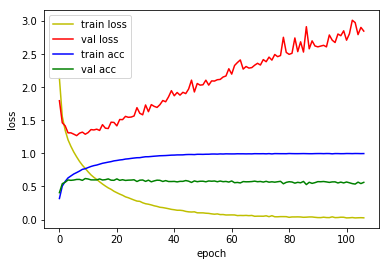

4815/4815 [==============================] - 1s 219us/sample - loss: 1.3207 - acc: 0.5836
Loss: 1.3206864595289418 Accuracy: 0.58359295

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9744 - acc: 0.3749
Epoch 00001: val_loss improved from inf to 1.58715, saving model to model/checkpoint/1D_CNN_BN_3_only_conv_checkpoint/001-1.5871.hdf5
36805/36805 [==============================] - 15s 414us/sample - loss: 1.9738 - acc: 0.3751 - val_loss: 1.5871 - val_acc: 0.4962
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3655 - acc: 0.5724
Epoch 00002: val_loss improved from 1.58715 to 1.24479, saving model to model/checkpoint/1D_CNN_BN_3_only_conv_checkpoint/002-1.2448.hdf5
36805/36805 [==============================] - 13s 345us/sample - loss: 1.3649 - acc: 0.5726 - val_loss: 1.2448 - val_acc: 0.6056
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1688 - acc: 0

36736/36805 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9904
Epoch 00055: val_loss did not improve from 0.66477
36805/36805 [==============================] - 13s 342us/sample - loss: 0.0670 - acc: 0.9904 - val_loss: 0.8312 - val_acc: 0.7980
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9922
Epoch 00056: val_loss did not improve from 0.66477
36805/36805 [==============================] - 12s 339us/sample - loss: 0.0631 - acc: 0.9921 - val_loss: 0.9565 - val_acc: 0.7710
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9888
Epoch 00057: val_loss did not improve from 0.66477
36805/36805 [==============================] - 13s 342us/sample - loss: 0.0714 - acc: 0.9888 - val_loss: 0.9491 - val_acc: 0.7761
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9938
Epoch 00058: val_loss did not improve from 0.66477
36805/36805 [==================

Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9967
Epoch 00085: val_loss did not improve from 0.66477
36805/36805 [==============================] - 12s 339us/sample - loss: 0.0301 - acc: 0.9967 - val_loss: 1.1645 - val_acc: 0.7624
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9945
Epoch 00086: val_loss did not improve from 0.66477
36805/36805 [==============================] - 13s 342us/sample - loss: 0.0383 - acc: 0.9945 - val_loss: 1.0364 - val_acc: 0.7803
Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9978
Epoch 00087: val_loss did not improve from 0.66477
36805/36805 [==============================] - 13s 340us/sample - loss: 0.0259 - acc: 0.9978 - val_loss: 0.9002 - val_acc: 0.7985
Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9956
Epoch 00088: val_loss did not improve from 0.66477
36805/36805 [=====

Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9981
Epoch 00115: val_loss did not improve from 0.66477
36805/36805 [==============================] - 13s 340us/sample - loss: 0.0182 - acc: 0.9980 - val_loss: 1.0355 - val_acc: 0.7918
Epoch 116/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9988
Epoch 00116: val_loss did not improve from 0.66477
36805/36805 [==============================] - 13s 343us/sample - loss: 0.0153 - acc: 0.9988 - val_loss: 1.3192 - val_acc: 0.7487
Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9947
Epoch 00117: val_loss did not improve from 0.66477
36805/36805 [==============================] - 12s 339us/sample - loss: 0.0307 - acc: 0.9948 - val_loss: 0.9366 - val_acc: 0.8088
Epoch 118/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9988
Epoch 00118: val_loss did not improve from 0.66477
36805/36805 [=

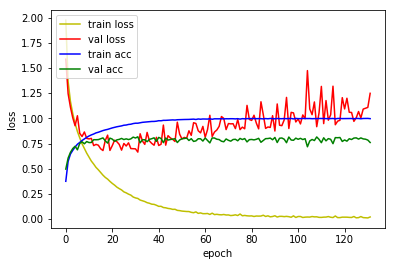

4815/4815 [==============================] - 1s 258us/sample - loss: 0.7525 - acc: 0.7890
Loss: 0.7524969367594734 Accuracy: 0.7889927

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9704 - acc: 0.3779
Epoch 00001: val_loss improved from inf to 1.66222, saving model to model/checkpoint/1D_CNN_BN_4_only_conv_checkpoint/001-1.6622.hdf5
36805/36805 [==============================] - 18s 498us/sample - loss: 1.9704 - acc: 0.3779 - val_loss: 1.6622 - val_acc: 0.4677
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2920 - acc: 0.6000
Epoch 00002: val_loss improved from 1.66222 to 1.18882, saving model to model/checkpoint/1D_CNN_BN_4_only_conv_checkpoint/002-1.1888.hdf5
36805/36805 [==============================] - 14s 378us/sample - loss: 1.2921 - acc: 0.6000 - val_loss: 1.1888 - val_acc: 0.6161
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0185 - acc: 0.

Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9899
Epoch 00054: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 370us/sample - loss: 0.0508 - acc: 0.9899 - val_loss: 0.3319 - val_acc: 0.9113
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9942
Epoch 00055: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 370us/sample - loss: 0.0368 - acc: 0.9942 - val_loss: 0.3332 - val_acc: 0.9185
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9936
Epoch 00056: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 371us/sample - loss: 0.0403 - acc: 0.9936 - val_loss: 0.3815 - val_acc: 0.9036
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9961
Epoch 00057: val_loss did not improve from 0.30026
36805/36805 [=====

Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9990
Epoch 00084: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 372us/sample - loss: 0.0116 - acc: 0.9990 - val_loss: 0.3881 - val_acc: 0.9047
Epoch 85/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9938
Epoch 00085: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 373us/sample - loss: 0.0271 - acc: 0.9938 - val_loss: 0.3182 - val_acc: 0.9201
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9992
Epoch 00086: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 372us/sample - loss: 0.0110 - acc: 0.9992 - val_loss: 0.3221 - val_acc: 0.9196
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9973
Epoch 00087: val_loss did not improve from 0.30026
36805/36805 [=====

Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9992
Epoch 00114: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 372us/sample - loss: 0.0064 - acc: 0.9992 - val_loss: 0.3512 - val_acc: 0.9243
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9996
Epoch 00115: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 373us/sample - loss: 0.0053 - acc: 0.9996 - val_loss: 0.3536 - val_acc: 0.9229
Epoch 116/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9961
Epoch 00116: val_loss did not improve from 0.30026
36805/36805 [==============================] - 14s 372us/sample - loss: 0.0171 - acc: 0.9961 - val_loss: 0.3295 - val_acc: 0.9269
Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9991
Epoch 00117: val_loss did not improve from 0.30026
36805/36805 [=

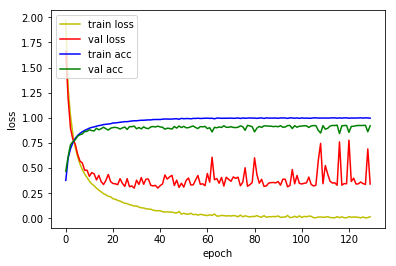

4815/4815 [==============================] - 1s 289us/sample - loss: 0.4007 - acc: 0.8804
Loss: 0.4007288916583868 Accuracy: 0.88037384

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6549 - acc: 0.4812
Epoch 00001: val_loss improved from inf to 1.26308, saving model to model/checkpoint/1D_CNN_BN_5_only_conv_checkpoint/001-1.2631.hdf5
36805/36805 [==============================] - 22s 587us/sample - loss: 1.6540 - acc: 0.4815 - val_loss: 1.2631 - val_acc: 0.5956
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9233 - acc: 0.7261
Epoch 00002: val_loss improved from 1.26308 to 0.75987, saving model to model/checkpoint/1D_CNN_BN_5_only_conv_checkpoint/002-0.7599.hdf5
36805/36805 [==============================] - 15s 407us/sample - loss: 0.9232 - acc: 0.7261 - val_loss: 0.7599 - val_acc: 0.7680
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6496 - acc: 0

36672/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9970
Epoch 00054: val_loss did not improve from 0.21400
36805/36805 [==============================] - 15s 400us/sample - loss: 0.0171 - acc: 0.9970 - val_loss: 0.2628 - val_acc: 0.9341
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9979
Epoch 00055: val_loss did not improve from 0.21400
36805/36805 [==============================] - 15s 401us/sample - loss: 0.0135 - acc: 0.9979 - val_loss: 0.2284 - val_acc: 0.9406
Epoch 56/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9954
Epoch 00056: val_loss did not improve from 0.21400
36805/36805 [==============================] - 15s 400us/sample - loss: 0.0214 - acc: 0.9954 - val_loss: 0.2570 - val_acc: 0.9324
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9979
Epoch 00057: val_loss did not improve from 0.21400
36805/36805 [==================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9996
Epoch 00113: val_loss did not improve from 0.21339
36805/36805 [==============================] - 15s 400us/sample - loss: 0.0029 - acc: 0.9996 - val_loss: 0.2798 - val_acc: 0.9387
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9982
Epoch 00114: val_loss did not improve from 0.21339
36805/36805 [==============================] - 15s 401us/sample - loss: 0.0075 - acc: 0.9982 - val_loss: 0.2333 - val_acc: 0.9429
Epoch 115/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9993
Epoch 00115: val_loss did not improve from 0.21339
36805/36805 [==============================] - 15s 402us/sample - loss: 0.0040 - acc: 0.9993 - val_loss: 0.2275 - val_acc: 0.9441
Epoch 116/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9989
Epoch 00116: val_loss did not improve from 0.21339
36805/36805 [=

Epoch 143/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9993
Epoch 00143: val_loss did not improve from 0.21339
36805/36805 [==============================] - 15s 399us/sample - loss: 0.0044 - acc: 0.9992 - val_loss: 0.2442 - val_acc: 0.9422
Epoch 144/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9973
Epoch 00144: val_loss did not improve from 0.21339
36805/36805 [==============================] - 15s 400us/sample - loss: 0.0103 - acc: 0.9973 - val_loss: 0.2374 - val_acc: 0.9427
Epoch 145/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9999
Epoch 00145: val_loss did not improve from 0.21339
36805/36805 [==============================] - 15s 400us/sample - loss: 0.0017 - acc: 0.9999 - val_loss: 0.2553 - val_acc: 0.9376
Epoch 146/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9993
Epoch 00146: val_loss did not improve from 0.21339
36805/36805 [=

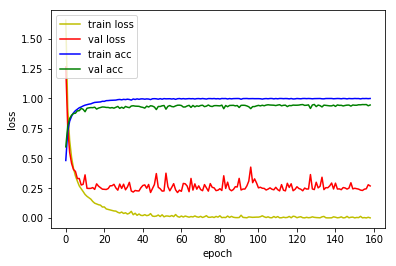

4815/4815 [==============================] - 1s 298us/sample - loss: 0.2892 - acc: 0.9288
Loss: 0.2892399005359764 Accuracy: 0.9287643



In [10]:
for i in range(1, 10):
    base = '1D_CNN_only_conv_conv_5_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_conv_5_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_conv_5_BN'

with open(path.join(log_dir, base)) as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, accuracy, loss])+'\n')


1D_CNN_BN_1_only_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 15976, 8)          32        
_________________________________________________________________
activation_15 (Activation)   (None, 15976, 8)          0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 31952)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                511248    
Total params: 511,488
Trainable params: 511,472
Non-trainable params: 16
________________________________________

4815/4815 [==============================] - 2s 317us/sample - loss: 0.4007 - acc: 0.8804
Loss: 0.4007288916583868 Accuracy: 0.88037384

1D_CNN_BN_5_only_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_25 (B (None, 15976, 8)          32        
_________________________________________________________________
activation_25 (Activation)   (None, 15976, 8)          0         
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
batch_normalization_v1_26 (B (None, 3970, 1